<a href="https://colab.research.google.com/github/jinyjib98/AI_Sprint_Project/blob/main/AI_05_%EA%B9%80%ED%98%95%EC%A7%84_Section4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section4 Project**


<br/>

## 🚀 Purpose

정의한 문제에 적절한 데이터셋을 고른 후, 가설을 검증하기 위한 딥러닝 모델 설계

<br/>

## 📖 Contents
-----
```
1. 문제 정의 및 데이터 선정
2. 모델 전처리 및 학습
3. 모델 성능 검증
4. 한계점 보완 및 발전방향 제시
```

### 1️⃣ 문제 정의 및 데이터 선정



#### 이모지(emoji)

> 유니코드 체계를 이용해 만든 그림문자 e.g. 😀 🥰 🤬

-> 그림을 통해 감정, 상황을 전달하는 메시지 수단

<br/>

❗️이모지의 장점

1. **직관적**으로 감정 표현 가능
2. 언어가 달라도 누구나 **쉽게 이해**할 수 있음

특히, 디지털 문화에 익숙한 젊은 세대를 중심으로 하나의 언어처럼 범용적으로 사용되고 있음

<br/>

-----

<br/>

#### 문제 정의

> 감정 분석을 통해 글에 어울리는 이모지를 추천해보자!

Angry, Fear, Sadness, Surprise, Joy, Love 총 6개의 감정으로 텍스트를 분류하는 LSTM 딥러닝 모델 설계

-> 분석 결과에 따라 감정별로 미리 분류된 이모지 리스트에서 랜덤으로 추천


#### Import Dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_url = '/content/drive/MyDrive/Section_Project/Section4/data/emozi/train.txt'
val_url = '/content/drive/MyDrive/Section_Project/Section4/data/emozi/val.txt'
test_url = '/content/drive/MyDrive/Section_Project/Section4/data/emozi/test.txt'

In [ ]:
train = pd.read_csv(train_url, sep=';', names=['text', 'sentiment'])
val = pd.read_csv(val_url, sep=';', names=['text', 'sentiment'])
test = pd.read_csv(test_url, sep=';', names=['text', 'sentiment'])

In [ ]:
train.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
val.head()

,text,sentiment
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [ ]:
test.head()

,text,sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


### 2️⃣ 모델 전처리 및 학습

#### 결측치 확인

In [ ]:
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
val.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
test.isnull().sum()

text         0
sentiment    0
dtype: int64

#### Value Counts

In [ ]:
train['sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

In [ ]:
val['sentiment'].value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: sentiment, dtype: int64

In [ ]:
test['sentiment'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentiment, dtype: int64

train, val, test 모두 생각보다 매우 깨끗한 데이터

- 결측치 없음

- train, val, test의 sentiment 비율이 비슷하게 구성되어 있어 따로 섞어줄 필요 없음

-> 전체 문자 lower 진행한 후 sentiment encoding으로 바로 들어감

#### Lowercase

In [ ]:
train['text'].str.isupper().sum()

0

In [ ]:
val['text'].str.isupper().sum()

0

In [ ]:
test['text'].str.isupper().sum()

0

In [ ]:
train.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


#### LabelEncoding

In [ ]:
train['sentiment'].unique().sort() == val['sentiment'].unique().sort() == test['sentiment'].unique().sort()

True

전체 데이터의 `sentiment` 요소가 같은 것 확인함 -> str - int 변환

In [ ]:
sentiment = {
    'anger' : 0,
    'fear' : 1,
    'sadness' : 2,
    'surprise': 3,
    'joy' : 4,
    'love' : 5
}

In [ ]:
train['sentiment'] = train['sentiment'].map(sentiment)
val['sentiment'] = val['sentiment'].map(sentiment)
test['sentiment'] = test['sentiment'].map(sentiment)

In [ ]:
train.head()

,text,sentiment
0,i didnt feel humiliated,2
1,i can go from feeling so hopeless to so damned...,2
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,5
4,i am feeling grouchy,0


#### Embedding Vector

> Tokenize 진행 후 Stemming(어간추출), Lemmatization(표제어 추출)에 따른 성능 비교 진행

In [ ]:
sum(train['text'].apply(len)) / len(train['text'])

96.8458125

In [ ]:
vocab_size = 10000
sentence_len = 150 # more than avg text length

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# stemming
def data_stem(data, text):
    stemmer = PorterStemmer()

    corpus = []

    for line in data[text]:

        # 영어 소문자, 숫자, 공백만 남김
        line = re.sub("[^a-z0-9]", " ", line)
        # tokenize
        line = line.split()

        # stemming
        line = [stemmer.stem(words)
                for words in line
                 if words not in stopwords.words("english")]
        
        line = " ".join(line)
        corpus.append(line)
    
    # one-hot vectorize
    one_hot_doc = [one_hot(input_text=words, n=vocab_size)
                    for words in corpus]
    
    # word embedding
    emb_doc = pad_sequences(sequences=one_hot_doc, maxlen=sentence_len, padding='pre')

    return emb_doc


In [ ]:
# lemmatization
def data_lemma(data, text):
    lemmatizer = WordNetLemmatizer()

    corpus = []

    for line in data[text]:

        # 영어 소문자, 숫자, 공백만 남김
        line = re.sub("[^a-z0-9]", " ", line)
        # tokenize
        line = line.split()

        # lemmatization
        line = [lemmatizer.lemmatize(words)
                for words in line
                 if words not in stopwords.words("english")]
        
        line = " ".join(line)
        corpus.append(line)
    
    # one-hot vectorize
    one_hot_doc = [one_hot(input_text=words, n=vocab_size)
                    for words in corpus]
    
    # word embedding
    emb_doc = pad_sequences(sequences=one_hot_doc, maxlen=sentence_len, padding='pre')

    return emb_doc

#### feature, target 분리

In [ ]:
# stemmed text
X_train_st = data_stem(train, 'text')
X_val_st = data_stem(val, 'text')
X_test_st = data_stem(test, 'text')

# lemmatized text
X_train_le = data_lemma(train, 'text')
X_val_le = data_lemma(val, 'text')
X_test_le = data_lemma(test, 'text')

# target
y_train = train['sentiment']
y_val = val['sentiment']
y_test = test['sentiment']

#### Baseline Model

다중분류 모델이므로 target 감정 중 가장 다수인 `Joy`만으로 예측하는 모델을 Baseline model로 선정 후 그 정확도를 모델의 최소 성능으로 설정함

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
major = y_train.mode()[0]

baseline_pred = [major] * len(y_train)

print(f'baseline accuracy: {accuracy_score(y_train, baseline_pred) * 100 :.2f}%')

baseline accuracy: 33.51%


#### Build Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# with random search - hypertuning
def build_model(hp):
    model = Sequential()

    model.add(Embedding(input_dim=vocab_size,
                        output_dim=hp.Int('output_dim', min_value=50, max_value=100, step=10),
                        input_length=sentence_len))
    
    model.add(LSTM(128))

    # hypertuning layers
    for i in range(hp.Int('Dense Layers', min_value=1, max_value=5, step=1)): 
        model.add(Dense(hp.Int('units_' + str(i), min_value=64, max_value=256, step=32),
                        activation='relu',
                        kernel_initializer=hp.Choice('kernal_init_' + str(i), values=['he_uniform', 'he_normal'])))
        
        model.add(Dropout(rate=hp.Float('drop_rate_' + str(i), min_value=0.3, max_value=0.5, step=0.1)))
        

    model.add(Dense(6, activation='softmax')) # multiple classification

    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[0.0001, 0.004, 0.01])), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

#### Set tuner

In [ ]:
pip install keras-tuner

In [ ]:
import keras_tuner
from keras_tuner.tuners import RandomSearch

#### Compare `stemmed ver` vs. `lemmatized ver`

In [ ]:
tuner_st = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='emoticonNLP', # save RandomSearch result 
    project_name='hypertuning_st'
)

In [ ]:
# stemmed
tuner_st.search(X_train_st, y_train,
             validation_data=(X_val_st, y_val),
             epochs=3)

Trial 3 Complete [00h 02m 30s]
val_accuracy: 0.8869999945163727

Best val_accuracy So Far: 0.8920000195503235
Total elapsed time: 00h 07m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model_st = tuner_st.get_best_models(num_models=1)[0]

In [ ]:
model_st.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           500000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3

In [ ]:
tuner_le = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='emoticonNLP', # save RandomSearch result 
    project_name='hypertuning_le'
)

In [ ]:
# lemmatized
tuner_le.search(X_train_le, y_train,
             validation_data=(X_val_le, y_val),
             epochs=3)

Trial 3 Complete [00h 02m 37s]
val_accuracy: 0.8937499821186066

Best val_accuracy So Far: 0.8937499821186066
Total elapsed time: 00h 07m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model_le = tuner_le.get_best_models(num_models=1)[0]

In [ ]:
model_le.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 60)           600000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               96768     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 731,334
Trainable params: 731,334
Non-trainable params: 0
_________________________________________________________________


|Type | Stemming | Lemmatization |
|:-----:|:--------:|:--------------:|
| Val_Accuracy | 0.8920 | 0.8937 |

<br/>

**Lemmatization** has a higher `val_accuracy`

-> `model_le`를 최종모델로 선정

#### Evaluate Model

In [ ]:
predict_classes = model_le.predict(X_test_le)

In [ ]:
y_pred = [np.argmax(label) for label in predict_classes]

In [ ]:
predict=pd.DataFrame(
    y_pred,
    columns=["predicted"]
)

In [ ]:
num_to_sentiment = {
    0 : 'anger',
    1 : 'fear',
    2 : 'sadness',
    3 : 'surprise',
    4 : 'joy',
    5 : 'love'
}

In [ ]:
predict['predicted'] = predict['predicted'].map(num_to_sentiment)

In [ ]:
import copy
pred = copy.deepcopy(test)

In [ ]:
pred['sentiment'] = pred['sentiment'].map(num_to_sentiment)

In [ ]:
prediction = pd.concat([pred, predict], axis=1)

In [ ]:
prediction.sample(10)

,text,sentiment,predicted
487,i kind of feel a little petty about this,anger,anger
1146,i feel affirmed gracious sensuous and will hav...,love,joy
1873,i entered the office though feeling the monday...,joy,joy
1073,i find it relaxes me and i feel productive mak...,joy,joy
1271,i feel more energetic,joy,joy
1783,i started to feel like i was going mad as i wa...,anger,anger
636,i feel so fearless in these post grieving days,joy,joy
21,i feel like ive gotten to know many of you thr...,joy,joy
1395,i sure would love to stop feeling so horny all...,love,love
1855,i really need to find my nitch up here in vt i...,sadness,sadness


In [ ]:
test_score = accuracy_score(y_test, y_pred)
con_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
print(f'Test Accuracy Score: {test_score * 100:.2f}%')

Test Accuracy Score: 89.80%


test data로 분석해본 결과, 꽤 좋은 정확도(89.80%) 보여줌

-> baseline model accuracy가 **33.51%**라는 점을 고려한다면 모델의 성능이 chance level을 넘을만큼 높다는 것을 알 수 있음

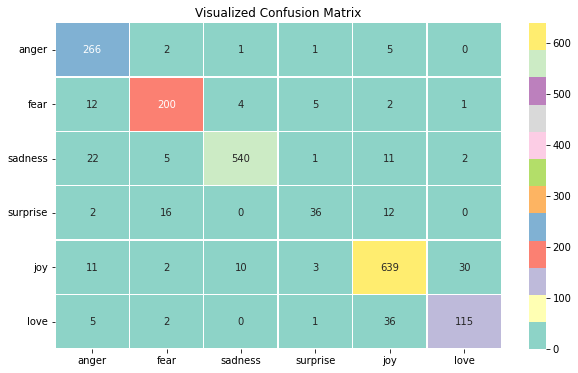

<Figure size 432x288 with 0 Axes>

In [ ]:
labels=["anger","fear","sadness","surprise","joy","love"]
fig=plt.figure(figsize=(10,6))
sns.heatmap(con_matrix,
            annot=True,
            fmt="d",
            xticklabels=labels,
            yticklabels=labels,
            cmap="Set3",
            linewidths=0.5
           )
plt.title("Visualized Confusion Matrix")
plt.yticks(rotation=0)
plt.show()
plt.savefig('confusion_matrix.png', dpi=100)

### 3️⃣ 모델 성능 검증 - 새로운 데이터 분석해보기

In [ ]:
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def emoji_classifier(model, text):

    for sentences in text:
        sentences = nltk.sent_tokenize(text) # 문장들을 한 문장씩 분리

        for sentence in sentences:
            words = re.sub("[^a-zA-Z0-9]", " ", sentence) #영소문자, 영대문자, 숫자만 받아들이기

            if words not in stopwords.words("english"):
                words = words.lower()
                word = nltk.word_tokenize(words) # 불용어 사전에 포함되는 단어 제외하고 단어별로 tokenize
                word = " ".join(word)
    
    one_hot_doc = [one_hot(word, n=vocab_size)] # one hot vectorize

    emb_doc = pad_sequences(one_hot_doc, maxlen=sentence_len, padding="pre") # word embedding

    predict_class = model.predict(emb_doc) # predict class of words

    # emoji list
    anger = ["\U0001F624", "\U0001F621", "\U0001F620", "\U0001F92C", "\U0001F47F", "\U0001F480", "\U0001F63E"]
    fear = ["\U0001F976", "\U0001F635", "\U0001F628", "\U0001F630", "\U0001F631", "\U0001F616", "\U0001F62B"]
    sadness = [u"\U0001F972", "\U0001F641", "\U0001F97A", "\U0001F625", "\U0001F622", "\U0001F62D", "\U0001F63F"]
    surprise = ["\U0001F92D", "\U0001F644", "\U0001F635", "\U0001F92F", "\U0001F62E", "\U0001F633", "\U0001F627"]
    joy = ["\U0001F600", "\U0001F606", "\U0001F923", "\U0001F60A", "\U0001F63A", "\U0001F917", "\U0001F973", "\U0001F638", "\U0001F44D", "\U0001F44F"]
    love = ["\U0001F970", "\U0001F60D", "\U0001F618", "\U0001F63B", "\U0001F498", "\U0001F496", "\U0001F495", "\U0001F9E1", "\U0001F49C", "\U0001F49B", "\U0001F499"]

    # predicted class -> class에 따른 emoji 2개 random으로 추천해줌
    y_pred = [np.argmax(label) for label in predict_class] 

    if y_pred == [0]:
        print('Predicted Sentiment is \"ANGER\"')
        print(f'Suggested emoji: {random.sample(anger, 2)}')
    
    elif y_pred == [1]:
        print('Predicted Sentiment is \"FEAR\"')
        print(f'Suggested emoji: {random.sample(fear, 2)}')
    
    elif y_pred == [2]:
        print('Predicted Sentiment is \"SADNESS\"')
        print(f'Suggested emoji: {random.sample(sadness, 2)}')
    
    elif y_pred == [3]:
        print('Predicted Sentiment is \"SURPRISE\"')
        print(f'Suggested emoji: {random.sample(surprise, 2)}')

    elif y_pred == [4]:
        print('Predicted Sentiment is \"JOY\"')
        print(f'Suggested emoji: {random.sample(joy, 2)}')
    
    elif y_pred == [5]:
        print('Predicted Sentiment is \"LOVE\"')
        print(f'Suggested emoji: {random.sample(love, 2)}')

In [ ]:
emotion1 = "I have tried several times to get back with you, but this aint working with us."

emoji_classifier(model_le, emotion1)

Predicted Sentiment is "ANGER"
Suggested emoji: ['😤', '👿']


In [ ]:
emotion2 = "Thank God! I feel so grateful to have you."

emoji_classifier(model_le, emotion2)

Predicted Sentiment is "SURPRISE"
Suggested emoji: ['😳', '😧']


In [ ]:
emotion3 = "oh my god! What the heck is that!"

emoji_classifier(model_le, emotion3)

Predicted Sentiment is "ANGER"
Suggested emoji: ['😡', '💀']


In [ ]:
emotion4 = "I feel so good right now!"

emoji_classifier(model_le, emotion4)

Predicted Sentiment is "JOY"
Suggested emoji: ['😀', '🥳']


### 4️⃣ 한계점 보완 및 발전방향 제시

#### 한계점 1: 뉘앙스 파악의 어려움

In [ ]:
emotion5 = "oh my god! Thank you so much!"

emoji_classifier(model_le, emotion5)

Predicted Sentiment is "FEAR"
Suggested emoji: ['😵', '😫']


똑같은 단어가 들어가면, 맥락이 달라도 비슷한 뜻으로 해석함

-> emotion3에서는 oh my god이 부정적인 뉘앙스이나, emotion5에서는 oh my god이 긍정적인 뉘앙스로 사용 

=> BUT, 모델은 모두 부정적으로 인식함

#### 한계점 2: 엉뚱한 판단

In [ ]:
emotion6 = "Hi! Nice to meet you"

emoji_classifier(model_le, emotion6)

Predicted Sentiment is "ANGER"
Suggested emoji: ['😠', '😡']


때로는 아주 말도안되는 예측 결과가 나오기도 함

-> 일반적으로 보기에는 `JOY`, `LOVE`가 나와야 할 것 같은데, `ANGER`로 예측됨

-----

#### 보완방법

<br/>

> **학습량 늘리기**

현재 모델의 경우 총 학습 epoch가 3으로 매우 적은 수준 

-> 학습량을 증가하여 모델의 성능이 올라가는지 확인

<br/>

> **새로운 모델 선정**

현재 사용한 모델은 LSTM으로 Transformer를 사용한 BERT와 같은 모델에 비해 속도, 성능면에서 부족한 부분 있음 

-> 새로운 모델로 학습 진행하여 최적화 시도

<br/>

> **다중분류(multiple classification) -> 이진분류(binary classification)**

일반적으로 다중분류에 비해 이진분류가 모델이 예측하기 쉬워 비교적 성능이 더 좋기 때문에, 성능을 높이기 위한 목적이라면 이진분류로 문제를 변경하는 것도 하나의 방법 (e.g. 긍정 vs. 부정)

-----

#### 발전 방향

<br/>

> **여러 언어 지원**

영어 뿐만 아니라 다른 언어(한국어 etc) 지원시 더 범용적으로 활용할 수 있음

<br/>

> **메신저 앱 적용**

기본 이모지 외에 카카오톡과 같은 메신저 앱에서 제공하는 이모티콘도 함께 추천하는 방향으로 발전

<br/>

> **실시간 추천**

단순히 리스트에 있는 이모지 중 랜덤으로 추천하는 것을 넘어, 같은 감정의 글을 쓴 사람들이 현재 많이 사용하는 이모지를 제시하는 방향 -> 트랜드 파악 가능